In [1]:
import antenna_new
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import numpy as np
from tensorflow.keras.utils import  plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from PIL import Image, ImageDraw
import pandas as pd
import seaborn as sns
from keras.callbacks import ModelCheckpoint
import keras.callbacks
import tensorflow.keras.losses
import os
import pydot

In [2]:
N = 15
Grid_size = 2000
d = 1/2

In [3]:
rel = 1.44/(d*(N-1))

In [92]:
rel

0.2057142857142857

In [4]:
antenna1 = antenna_new.antenna(N, Grid_size)

In [5]:
a = antenna1.cosine_Amplitude_distr(0,0)

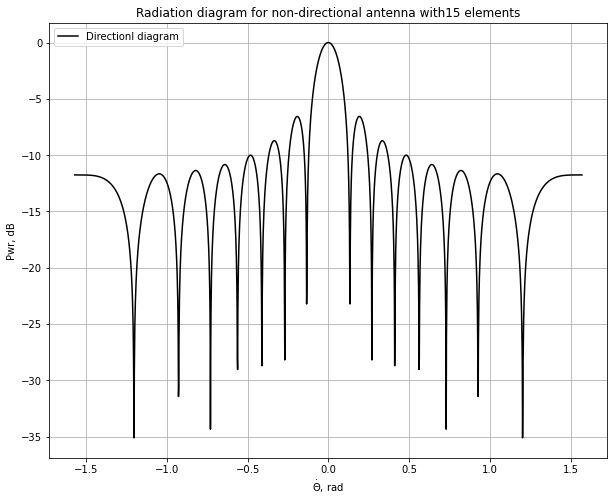

In [6]:
antenna1.plot_dd()

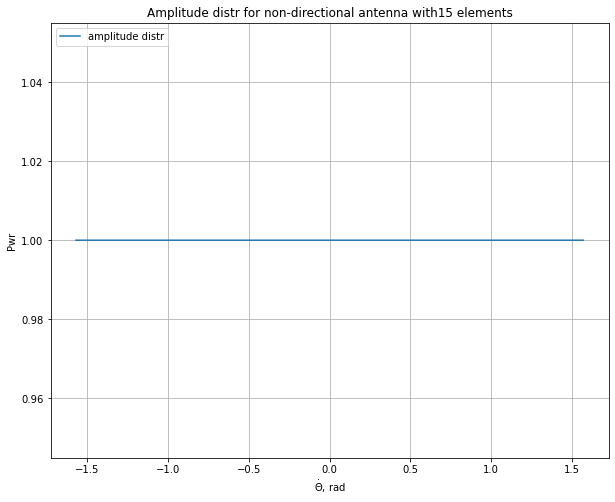

In [7]:
antenna1.plot_distr()

In [8]:
def create_dataset(grid_size, N):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    N = np.matrix(np.linspace(0,N-1,N)).transpose()
    grid_size = grid_size
    Grid = np.linspace(-90, 90, grid_size)*np.pi/180
    records = []
    for k in range(1,grid_size//2- 2):
        idx = Grid[k]
        idx2 = Grid[grid_size-k]
        Nn = len(N)
        cov_m = np.zeros((Nn,Nn))
        UI = np.sin(idx)
        UI2= np.sin(idx2)

        VI = np.exp(1j * np.pi * N * UI)
        VI2= np.exp(1j * np.pi * N * UI2)

        cov_m = 10*VI@VI.transpose() + 10*VI2@VI2.transpose()

        S_thetta = np.exp(1j * np.pi * N * np.sin(Grid))

        P = np.zeros(np.shape(S_thetta))

        for i in range(0,max(np.shape(Grid))):
            a = S_thetta[:,i]
            P[:,i] = (a.transpose().conj()@(np.linalg.inv(cov_m)@np.linalg.inv(cov_m))@a)
            pass
        P = 1/np.sum(P,axis = 0)
        P = np.log10(abs(P))
        P = P - max(P)
        P = P / max(abs(P))

        records.append([cov_m, P, idx, idx2])

    
    df = pd.DataFrame(records)
    
    df.columns = ['cov_m', 'P', 'loc1', 'loc2']
    df = df.dropna()
    
    return df

df = create_dataset(2000,15)
df.head()

<ipython-input-8-b8c2f65bada0>:29: ComplexWarning: Casting complex values to real discards the imaginary part
  P[:,i] = (a.transpose().conj()@(np.linalg.inv(cov_m)@np.linalg.inv(cov_m))@a)


,cov_m,P,loc1,loc2
0,[[[[[ 20. +0.00000000e+00j -20. ...,"[-0.0007949059660157874, -0.001101033716547601...",-1.569225,1.570796
1,[[[[[ 20. +0.j -20. -0.0...,"[-0.021678031273113695, -0.0316353700268358, -...",-1.567653,1.569225
2,[[[[[ 20. +0.j -19.99999999-0.0...,"[-0.06273634121668588, -0.06485680679088648, -...",-1.566082,1.567653
3,[[[[[ 20. +0.j -19.99999997-0.0...,"[-0.17627942716979586, -0.17182671442593114, -...",-1.564510,1.566082
4,[[[[[ 20. +0.j -19.99999993-0.0...,"[-0.0686434231443556, -0.07040372269509422, -0...",-1.562938,1.564510


In [9]:
class DataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_idx = p[:]
        
        return train_idx
    def generate_data(self, image_idx, is_training, batch_size):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        cov_m, P = [], []
        while True:
            for idx in image_idx:
                imag = self.df.iloc[idx]
                
                cov_m_ = imag['cov_m']
                P_ = imag['P']
                
                cov_m.append(cov_m_)
                P.append(P_)
                # yielding condition
                if len(cov_m) >= batch_size:
                    yield np.array(cov_m), np.array(P)
                    cov_m, P = [], []
                    
            if not is_training:
                break
                
                
data_generator = DataGenerator(df)
train_idx = data_generator.generate_split_indexes()  

In [11]:
model = tf.keras.models.load_model()

In [12]:
Grid = np.linspace(-90, 90, 2000)*np.pi/180

In [93]:
loc = 99
train_idx = data_generator.generate_split_indexes() 
test_gen =   data_generator.generate_data([loc], is_training=False, batch_size=1)

Text(0, 0.5, 'Pwr, dB')

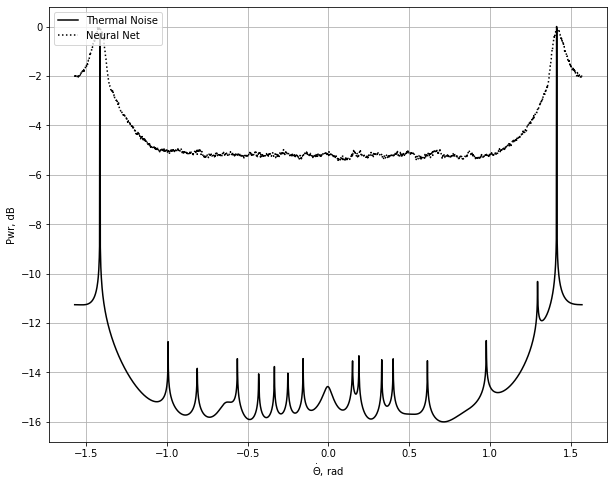

In [94]:
tic = time.perf_counter()
c = model.predict(test_gen,steps=len(train_idx))
toc = time.perf_counter()
time = abs(tic-toc)
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
linen, = ax1.plot(Grid,(df['P'][loc]*16).transpose(),'black', label='Thermal Noise', ls = '-')
linenn, = ax1.plot(Grid,((c[0]- max(c[0]))*16),'black', label='Neural Net', ls = ':')
#ax1.set_title('Directional diagram for ' + self.type + ' antenna with' + str(self.N) + ' elements')
ax1.grid(True)
ax1.legend(handles=[linenn])
ax1.legend(loc='upper left')
ax1.set_xlabel(r"$\dot{\Theta}$, rad")
ax1.set_ylabel('Pwr, dB')

In [82]:
maxx = -100
for i in range(0,1999):
    if c[0][i]>maxx:
        idx = i
        maxx = c[0][i]
print(idx)

978


In [95]:
time

0.03902829999969981